In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import datetime
import cftime
import pandas as pd
import sys
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import xesmf as xe
from scipy import linalg
from scipy import stats
import cmocean
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from matplotlib.patches import Rectangle

sns.set_style("whitegrid")
import matplotlib as mpl
dpi = 100
mpl.rcParams['figure.dpi'] = dpi
sns.set_context("notebook")


sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from sparse_obs_tools import *

In [42]:
sigma = 37.00
toSv = 1/1035*1e-6
toTg = 1e-9 

mass_flux_units = "Tg/s"
mass_flux_units_conversion = toTg

expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"

yearly_average = lambda ds: ds.groupby("time.year").mean("time")
ds_columns_forced = xr.open_dataset(
        datadir("/model/Tracer_Columns_SFC_250_forced.nc"))

ds_columns_control = xr.open_dataset(
        datadir("/model/Tracer_Columns_SFC_250_control.nc"))
ds_columns_control.coords['time'] = ds_columns_forced.time.values

ds_columns = xr.concat([
    yearly_average(ds_columns_forced).expand_dims(exp=['forced']),
    yearly_average(ds_columns_control).expand_dims(exp=['control'])
], dim='exp')


sfc_props = xr.open_dataset(datadir("model/Southern_Ocean_Surface_Properties.nc"))
sfc_props = yearly_average(sfc_props)
sfc_props["ant_mask"] = sfc_props["ant_mask"].mean("year")

In [4]:
def area_average(ds, varname, mask = None):
    if mask is None:
        mask = 1
        
    numerator = mask * ds[varname] * ds["areacello"] * ds["wet"]
    denominator = mask * ds["areacello"] * ds["wet"]
    numerator = numerator.where(denominator > 0)
    denominator = denominator.where(denominator > 0)
    return numerator.sum(["xh", "yh"]) / denominator.sum(["xh", "yh"])


In [5]:
antarctic_mask = ds_columns.lat < -40

In [50]:
cfc_average = area_average(ds_columns, "cfc11", mask = antarctic_mask)
dsvars = ["tos", "siconc"]
sfc_props_average = xr.merge([area_average(sfc_props, var, mask = sfc_props["ant_mask"]).rename(var) for var in dsvars])

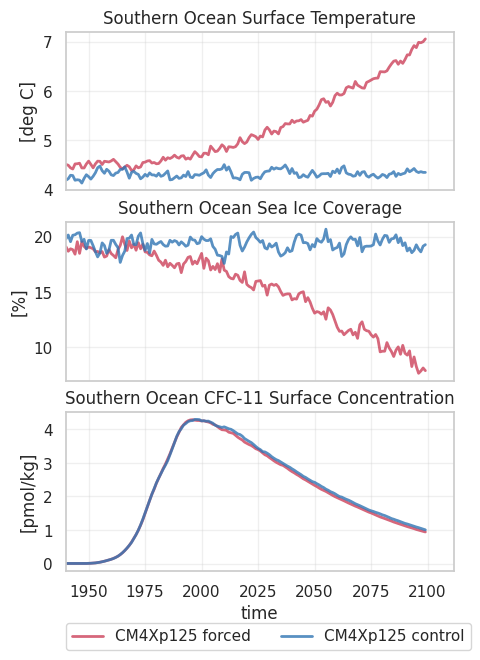

In [101]:
cfcconversion = 1e12 / 1035

# Create plots

fig, axes = plt.subplots(3, 1, figsize=(5.0, 7), sharex=True)

for (i, scenario) in enumerate(["forced", "control"]):

    axes[0].plot(sfc_props_average.year, sfc_props_average.tos.sel(exp = scenario), 
            label = scenario, c = expt_colors[scenario], lw = 2, alpha = 0.8)
    axes[0].set_title("Southern Ocean Surface Temperature")
    axes[0].set_ylabel("[deg C]")
    
    axes[1].plot(sfc_props_average.year, 100 * sfc_props_average.siconc.sel(exp = scenario), 
            label = scenario, c = expt_colors[scenario], lw = 2, alpha = 0.8)
    axes[1].set_title("Southern Ocean Sea Ice Coverage")
    axes[1].set_ylabel("[%]")
    
    axes[2].plot(cfc_average.year, cfcconversion * cfc_average.sel(exp = scenario), 
            label = f"CM4Xp125 {scenario}", c = expt_colors[scenario], lw = 2, alpha = 0.8)
    axes[2].set_title("Southern Ocean CFC-11 Surface Concentration")
    axes[2].set_ylabel("[pmol/kg]")
    axxy = (cfc_average.year[-75], cfcconversion * cfc_average.sel(exp = scenario)[-1])

axes[2].legend(frameon = True, loc = (0, -0.5), ncols = 2)
axes[2].set_xlim(1940, None)
axes[2].set_xlabel("time")
[a.grid(alpha = 0.3) for a in axes]
fig.savefig(plotsdir("supp_paper_figures/Surface_Properties_SouthernOcean.png"), dpi = 200, bbox_inches = "tight")


/tmp/ipykernel_232192/1563211885.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend(frameon = True, loc = (0, -0.5), ncols = 2)


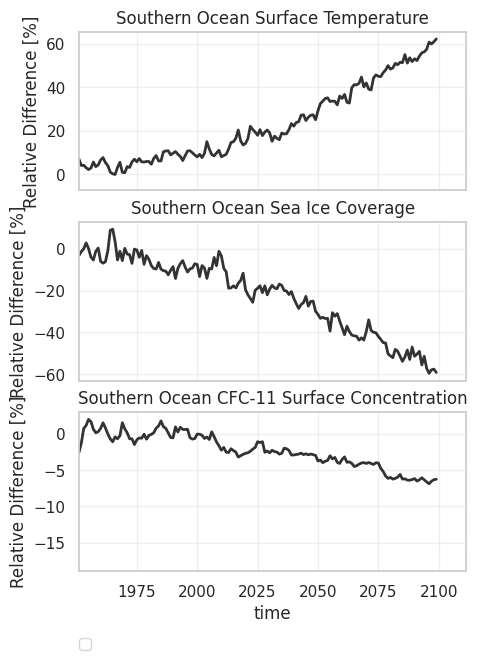

In [106]:
cfcconversion = 1e12 / 1035

# Create plots

fig, axes = plt.subplots(3, 1, figsize=(5.0, 7), sharex=True)

perc_diff = (sfc_props_average.sel(exp = "forced") - sfc_props_average.sel(exp = "control")) / sfc_props_average.sel(exp = "control")

axes[0].plot(sfc_props_average.year, 100 * perc_diff.tos, c = "k", lw = 2, alpha = 0.8)
axes[0].set_title("Southern Ocean Surface Temperature")
axes[0].set_ylabel("Relative Difference [%]")

axes[1].plot(sfc_props_average.year, 100 * perc_diff.siconc, c = "k", lw = 2, alpha = 0.8)
axes[1].set_title("Southern Ocean Sea Ice Coverage")
axes[1].set_ylabel("Relative Difference [%]")

perc_diff = (cfc_average.sel(exp = "forced") - cfc_average.sel(exp = "control")) / cfc_average.sel(exp = "control")
axes[2].plot(cfc_average.year, 100 * perc_diff, c = "k", lw = 2, alpha = 0.8)
axes[2].set_title("Southern Ocean CFC-11 Surface Concentration")
axes[2].set_ylabel("Relative Difference [%]")


axes[2].legend(frameon = True, loc = (0, -0.5), ncols = 2)
axes[2].set_xlim(1951, None)
axes[2].set_xlabel("time")
[a.grid(alpha = 0.3) for a in axes]
fig.savefig(plotsdir("supp_paper_figures/Surface_Properties_Diff_SouthernOcean.png"), dpi = 200, bbox_inches = "tight")
